In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import TraceDict
from einops import rearrange, einsum
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
from datasets import Dataset
from torch.utils.data import DataLoader, SequentialSampler
import analysis_utils
# from model_aligner_script import load_data
from counterfactual_datasets.entity_tracking import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./llama_7b"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(DEVICE)
tokenizer.pad_token_id = tokenizer.eos_token_id

model.eval()
for param in model.parameters():
    param.requires_grad_(False)

Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]


In [3]:
NUM_HEADS = model.config.num_attention_heads
HEAD_SIZE = model.config.hidden_size // NUM_HEADS

## Desiderata

In [119]:
def load_data(raw_data, batch_size):
    train_size = int(0.6 * len(raw_data[0]))
    eval_size = int(0.4 * len(raw_data[0]))

    print("Train size: ", train_size)
    print("Eval size: ", eval_size)
    print("Test size: ", len(raw_data[0]) - train_size - eval_size)

    raw_train = (
        raw_data[0][:train_size],
        raw_data[1][:train_size],
        raw_data[2][:train_size],
        raw_data[3][:train_size],
        raw_data[4][:train_size],
    )
    raw_eval = (
        raw_data[0][train_size : train_size + eval_size],
        raw_data[1][train_size : train_size + eval_size],
        raw_data[2][train_size : train_size + eval_size],
        raw_data[3][train_size : train_size + eval_size],
        raw_data[4][train_size : train_size + eval_size],
    )
    raw_test = (
        raw_data[0][train_size + eval_size :],
        raw_data[1][train_size + eval_size :],
        raw_data[2][train_size + eval_size :],
        raw_data[3][train_size + eval_size :],
        raw_data[4][train_size + eval_size :],
    )

    train_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_train[0],
            "base_input_last_pos": raw_train[1],
            "source_input_ids": raw_train[2],
            "source_input_last_pos": raw_train[3],
            "labels": raw_train[4],
        }
    ).with_format("torch")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
    )

    eval_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_eval[0],
            "base_input_last_pos": raw_eval[1],
            "source_input_ids": raw_eval[2],
            "source_input_last_pos": raw_eval[3],
            "labels": raw_eval[4],
        }
    ).with_format("torch")
    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
    )

    test_dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_test[0],
            "base_input_last_pos": raw_test[1],
            "source_input_ids": raw_test[2],
            "source_input_last_pos": raw_test[3],
            "labels": raw_test[4],
        }
    ).with_format("torch")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
    )

    return train_dataloader, eval_dataloader, test_dataloader

In [192]:
data_file_path = "./box_datasets/no_instructions/alternative/Random/3/train.jsonl"
object_file_path = "./box_datasets/filtered_objects_with_bnc_frequency.csv"

raw_data = correct_object_position_fetcher_desiderata(
    tokenizer=tokenizer,
    num_samples=600,
    data_file=data_file_path,
    object_file=object_file_path,
    num_boxes=3,
    alt_format=True,
)

In [193]:
objValueFetcher_train, objValueFetcher_eval, objValueFetcher_test = load_data(
    raw_data=raw_data, batch_size=40
)

# objValueFetcher_train_2, objValueFetcher_eval_2, objValueFetcher_test_2 = load_data(
#     raw_data=raw_data, batch_size=40
# )

Train size:  360
Eval size:  240
Test size:  0


In [194]:
desiderata_train = [objValueFetcher_train]
desiderata_eval = [objValueFetcher_eval]
desiderata_test = [objValueFetcher_test]

In [195]:
data = next(enumerate(desiderata_train[0]))[1]
bi = 1
print(tokenizer.decode(data["base_input_ids"][bi][: data["base_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["source_input_ids"][bi][: data["source_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["labels"][bi]))

 The fig is in Box X, the engine is in Box T, the radio is in Box A. Box T contains the
 There are a bunch of boxes containing objects. The crown is in Box R, the creature is in Box D, the phone is in Box C. Box D contains the
 engine


## Training Binary Mask

In [196]:
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(32)]

In [197]:
from_activations_train = {}

for di, desid_train in enumerate(desiderata_train):
    from_activations_train[di] = {}

    for bi, inputs in enumerate(desid_train):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_train[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_train[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_train[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [198]:
from_activations_eval = {}

for di, desid_eval in enumerate(desiderata_eval):
    from_activations_eval[di] = {}

    for bi, inputs in enumerate(desid_eval):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_eval[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_eval[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_eval[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [199]:
modules_w_heads = []
for module in modules:
    if "self_attn" in module:
        for head in range(32):
            modules_w_heads.append(f"{module}.{head}")
    else:
        modules_w_heads.append(module)

mask_dict = {module: i for i, module in enumerate(modules_w_heads)}

In [200]:
def edit_output(
    inputs=None,
    output=None,
    layer=None,
    mask=None,
    from_activations=None,
    to_last_token_pos=None,
    from_last_token_pos=None,
    rel_pos=None,
):
    if "self_attn" in layer:
        inp = inputs[0]
        from_activations[layer] = from_activations[layer].to(DEVICE)

        # Computing the output of each head in this layer after the intervention
        for head_idx in range(NUM_HEADS):
            head_start = head_idx * HEAD_SIZE
            head_end = (head_idx + 1) * HEAD_SIZE
            abl_amt = mask[mask_dict[f"{layer}.{head_idx}"]]

            for bi in range(inp.shape[0]):
                intervention = (
                    abl_amt * inp[bi, to_last_token_pos[bi] - rel_pos, head_start:head_end].clone()
                    + (1 - abl_amt)
                    * from_activations[layer][bi, from_last_token_pos[bi] - rel_pos, head_start:head_end]
                )
                inp[bi, to_last_token_pos[bi] - rel_pos, head_start:head_end] = intervention

        from_activations[layer] = from_activations[layer].to("cpu")

        weights = model.state_dict()[f"{layer}.weight"]
        mod_output = einsum(
            inp, weights, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
        )

        del weights
        torch.cuda.empty_cache()
        return mod_output

    else:
        assert False, "shouldn't be here"

In [201]:
def compute_heads_from_mask(rounded):
    masked_heads = []
    inverse_mask_dict = {v: k for k, v in mask_dict.items()}

    for mask_idx in (rounded == 0).nonzero()[:, 0]:
        layer = inverse_mask_dict[mask_idx.item()]
        layer_idx = int(layer.split(".")[2])
        head_idx = int(layer.split(".")[-1])
        masked_heads.append([layer_idx, head_idx])

    return masked_heads

In [202]:
mask = {}
epochs = 3
rel_pos = 0
log_steps = 2
eval_steps = 4
save_path = "./masks/reverse/last_pos_new/correct_object_position_fetcher_new"

for lamb in [0.1, 0.15, 0.2, 0.25, 0.3]:
    mask[lamb] = torch.ones(
        len(modules_w_heads), requires_grad=True, device=DEVICE, dtype=torch.float
    )
    optimizer = torch.optim.Adam([mask[lamb]], lr=1e-1)
    eval_acc = 0

    for epoch in range(epochs):
        for di, desid_train in enumerate(desiderata_train):
            for bi, inputs in enumerate(desid_train):
                mask[lamb].data.clamp_(0, 1)
                optimizer.zero_grad()

                with TraceDict(
                    model,
                    modules,
                    edit_output=partial(
                        edit_output,
                        mask=mask[lamb],
                        from_activations=from_activations_train[di][bi],
                        to_last_token_pos=inputs["base_input_last_pos"],
                        from_last_token_pos=inputs["source_input_last_pos"],
                        rel_pos=rel_pos,
                    ),
                ) as _:
                    output = model(inputs["base_input_ids"].to(DEVICE))

                target_logits = 0
                for idx in range(inputs["base_input_ids"].size(0)):
                    target = inputs["labels"][idx]
                    target_logits += output.logits[idx, inputs["base_input_last_pos"][idx], target]
                target_logits /= inputs["base_input_ids"].size(0)

                # maximize the target logits => minimize the negative target logits
                # minimize the number of heads => maximize #ones in the mask
                loss = -target_logits + lamb * torch.sum(1 - mask[lamb])

                loss.backward()
                optimizer.step()

                if bi % log_steps == 0:
                    print(
                        f"epoch: {epoch}, bi: {bi}, Loss: {loss.item()}, Target logits: {target_logits.item()}"
                    )
                
                if bi % eval_steps == 0:
                    with torch.inference_mode():
                        mask_data = mask[lamb].data.clone()
                        mask_data.clamp_(0, 1)
                        rounded = torch.round(mask_data)
                        heads = compute_heads_from_mask(rounded)
                        print(f"lamb: {lamb}, #Zero heads: {(rounded == 0).nonzero().shape[0]}")
                        print(heads)

                        correct, total = 0, 0
                        for eval_di, desid_eval in enumerate(desiderata_eval):
                            for eval_bi, eval_inputs in enumerate(desid_eval):
                                with TraceDict(
                                    model,
                                    modules,
                                    edit_output=partial(
                                        edit_output,
                                        mask=rounded,
                                        from_activations=from_activations_eval[eval_di][eval_bi],
                                        to_last_token_pos=eval_inputs["base_input_last_pos"],
                                        from_last_token_pos=eval_inputs["source_input_last_pos"],
                                        rel_pos=rel_pos,
                                    ),
                                ) as _:
                                    eval_output = model(eval_inputs["base_input_ids"].to(DEVICE))

                                for idx in range(eval_inputs["base_input_ids"].size(0)):
                                    target = eval_inputs["labels"][idx]
                                    pred = torch.argmax(eval_output.logits[idx, eval_inputs["base_input_last_pos"][idx]])

                                    if target == pred:
                                        correct += 1
                                    total += 1

                                del eval_output
                                torch.cuda.empty_cache()

                        acc = correct / total
                        if acc > eval_acc:
                            eval_acc = acc
                            torch.save(mask[lamb].data, f"{save_path}/{lamb}")

                        print(f"lamb: {lamb}, Validation Accuracy: {acc}\n")

            del output
            torch.cuda.empty_cache()

epoch: 0, bi: 0, Loss: -11.444095611572266, Target logits: 11.444095611572266
lamb: 0.1, #Zero heads: 0
[]
lamb: 0.1, Validation Accuracy: 0.11666666666666667

epoch: 0, bi: 2, Loss: -12.54464340209961, Target logits: 12.820212364196777
epoch: 0, bi: 4, Loss: -12.65518569946289, Target logits: 13.186975479125977
lamb: 0.1, #Zero heads: 1
[[14, 27]]
lamb: 0.1, Validation Accuracy: 0.22083333333333333

epoch: 0, bi: 6, Loss: -12.839062690734863, Target logits: 13.59594440460205
epoch: 0, bi: 8, Loss: -13.451740264892578, Target logits: 14.405669212341309
lamb: 0.1, #Zero heads: 11
[[11, 23], [13, 1], [14, 0], [14, 27], [16, 2], [16, 16], [16, 17], [17, 25], [19, 12], [19, 18], [29, 24]]
lamb: 0.1, Validation Accuracy: 0.7333333333333333

epoch: 1, bi: 0, Loss: -12.849929809570312, Target logits: 13.886326789855957
lamb: 0.1, #Zero heads: 11
[[11, 23], [13, 1], [14, 0], [14, 27], [16, 2], [16, 16], [16, 17], [17, 25], [19, 12], [19, 18], [29, 24]]
lamb: 0.1, Validation Accuracy: 0.7333333

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:77                                                                                   │
│                                                                                                  │
│   74 │   │   │   │   │   │   │   │   │   │   rel_pos=rel_pos,                                    │
│   75 │   │   │   │   │   │   │   │   │   ),                                                      │
│   76 │   │   │   │   │   │   │   │   ) as _:                                                     │
│ ❱ 77 │   │   │   │   │   │   │   │   │   eval_output = model(eval_inputs["base_input_ids"].to    │
│   78 │   │   │   │   │   │   │   │                                                               │
│   79 │   │   │   │   │   │   │   │   for idx in range(eval_inputs["base_input_ids"].size(0)):    │
│   80 │   │   │   │   │   │   │   │   │   target = eval_inputs["labels"][idx]                     │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/transformers/models/llama/mode │
│ ling_llama.py:765 in forward                                                                     │
│                                                                                                  │
│   762 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return   │
│   763 │   │                                                                                      │
│   764 │   │   # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)    │
│ ❱ 765 │   │   outputs = self.model(                                                              │
│   766 │   │   │   input_ids=input_ids,                                                           │
│   767 │   │   │   attention_mask=attention_mask,                                                 │
│   768 │   │   │   past_key_values=past_key_values,                                               │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)    

## Testing Learned Mask

In [386]:
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(model.config.num_hidden_layers)]

In [387]:
from_activations_eval = {}

for di, desid_test in enumerate(desiderata_test):
    from_activations_eval[di] = {}

    for bi, inputs in enumerate(desid_test):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(DEVICE)

        from_activations_eval[di][bi] = {}
        with torch.no_grad():
            with TraceDict(model, modules, retain_input=True) as trace:
                _ = model(inputs["source_input_ids"])

                for module in modules:
                    if "self_attn" in module:
                        from_activations_eval[di][bi][module] = trace[module].input.detach().cpu()
                    else:
                        from_activations_eval[di][bi][module] = trace[module].output.detach().cpu()

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cpu")

        del trace
        torch.cuda.empty_cache()

In [388]:
path = './masks/reverse/last_pos_new/box_label_value_fetcher/'
masks = sorted([float(mask) for mask in os.listdir(path) if '.png' not in mask])
rel_pos = 0

num_heads, valid_acc = [], []
for lamb in masks:
    with torch.no_grad():
        mask = torch.load(f"{path}/{lamb}")
        mask.clamp_(0, 1)
        rounded = torch.round(mask.data)
        heads = compute_heads_from_mask(rounded)
        print(f"lamb: {lamb}, #Zero heads: {(rounded == 0).nonzero().shape[0]}")
        print(heads)

        correct, total = 0, 0
        for di, desid_test in enumerate(desiderata_test):
            for bi, inputs in enumerate(desid_test):
                with TraceDict(
                    model,
                    modules,
                    edit_output=partial(
                        edit_output,
                        mask=rounded,
                        from_activations=from_activations_eval[di][bi],
                        to_last_token_pos=inputs["base_input_last_pos"],
                        from_last_token_pos=inputs["source_input_last_pos"],
                        rel_pos=rel_pos,
                    ),
                ) as _:
                    output = model(inputs["base_input_ids"].to(DEVICE))

                for idx in range(inputs["base_input_ids"].size(0)):
                    target = inputs["labels"][idx]
                    pred = torch.argmax(output.logits[idx, inputs["base_input_last_pos"][idx]])

                    if target == pred:
                        correct += 1
                    total += 1

                del output
                torch.cuda.empty_cache()

        num_heads.append((rounded == 0).nonzero().shape[0])
        valid_acc.append(correct / total)
        print(f"lamb: {lamb}, Test Accuracy: {correct / total}\n")

lamb: 0.05, #Zero heads: 15
[[8, 4], [11, 23], [12, 23], [13, 27], [14, 0], [14, 1], [14, 27], [15, 18], [15, 29], [16, 16], [16, 17], [19, 12], [20, 26], [31, 14], [31, 26]]
lamb: 0.05, Test Accuracy: 0.775

lamb: 0.1, #Zero heads: 6
[[11, 23], [12, 23], [14, 0], [14, 27], [31, 14], [31, 26]]
lamb: 0.1, Test Accuracy: 0.6916666666666667

lamb: 0.15, #Zero heads: 6
[[11, 23], [12, 23], [14, 0], [14, 27], [31, 14], [31, 26]]
lamb: 0.15, Test Accuracy: 0.6916666666666667

lamb: 0.2, #Zero heads: 4
[[11, 23], [12, 23], [14, 27], [31, 14]]
lamb: 0.2, Test Accuracy: 0.5416666666666666

lamb: 0.25, #Zero heads: 4
[[11, 23], [12, 23], [14, 27], [31, 14]]
lamb: 0.25, Test Accuracy: 0.5416666666666666

lamb: 0.3, #Zero heads: 3
[[11, 23], [14, 27], [31, 14]]
lamb: 0.3, Test Accuracy: 0.4166666666666667



In [389]:
path = './masks/reverse/last_pos_new/correct_object_position_fetcher/'
masks = sorted([float(mask) for mask in os.listdir(path) if '.png' not in mask])
rel_pos = 0

num_heads, valid_acc = [], []
for lamb in masks:
    with torch.no_grad():
        mask = torch.load(f"{path}/{lamb}")
        mask.clamp_(0, 1)
        rounded = torch.round(mask.data)
        heads = compute_heads_from_mask(rounded)
        print(f"lamb: {lamb}, #Zero heads: {(rounded == 0).nonzero().shape[0]}")
        print(heads)

        # correct, total = 0, 0
        # for di, desid_test in enumerate(desiderata_test):
        #     for bi, inputs in enumerate(desid_test):
        #         with TraceDict(
        #             model,
        #             modules,
        #             edit_output=partial(
        #                 edit_output,
        #                 mask=rounded,
        #                 from_activations=from_activations_eval[di][bi],
        #                 to_last_token_pos=inputs["base_input_last_pos"],
        #                 from_last_token_pos=inputs["source_input_last_pos"],
        #                 rel_pos=rel_pos,
        #             ),
        #         ) as _:
        #             output = model(inputs["base_input_ids"].to(DEVICE))

        #         for idx in range(inputs["base_input_ids"].size(0)):
        #             target = inputs["labels"][idx]
        #             pred = torch.argmax(output.logits[idx, inputs["base_input_last_pos"][idx]])

        #             if target == pred:
        #                 correct += 1
        #             total += 1

        #         del output
        #         torch.cuda.empty_cache()

        # num_heads.append((rounded == 0).nonzero().shape[0])
        # valid_acc.append(correct / total)
        # print(f"lamb: {lamb}, Test Accuracy: {correct / total}\n")

lamb: 0.05, #Zero heads: 15
[[11, 23], [12, 23], [12, 25], [13, 1], [14, 0], [14, 1], [14, 27], [16, 2], [16, 16], [17, 25], [19, 12], [19, 18], [25, 24], [26, 19], [29, 24]]
lamb: 0.1, #Zero heads: 9
[[11, 23], [12, 23], [13, 1], [14, 0], [14, 27], [16, 2], [17, 25], [19, 12], [29, 24]]
lamb: 0.15, #Zero heads: 6
[[11, 23], [13, 1], [14, 0], [14, 27], [16, 2], [19, 12]]
lamb: 0.2, #Zero heads: 5
[[13, 1], [14, 0], [14, 27], [16, 2], [19, 12]]


In [ ]:
[[11, 23], [12, 23], [14, 27], [31, 14]]

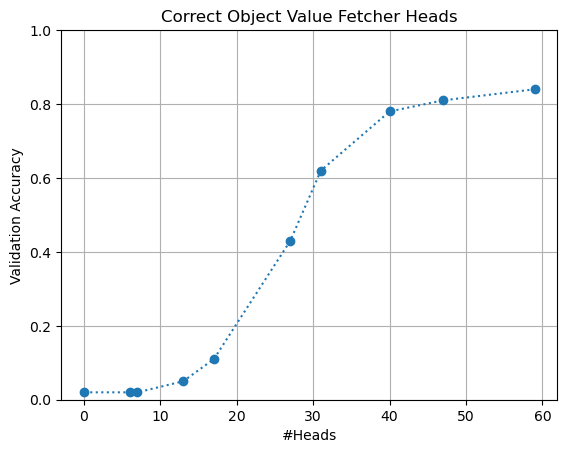

In [78]:
# Plot valid_acc vs num_heads

plt.plot(num_heads, valid_acc, "o:")
plt.xlabel("#Heads")
plt.ylabel("Validation Accuracy")
plt.title("Correct Object Value Fetcher Heads")
plt.ylim(0, 1)
plt.grid()

plt.show()

## Comparison with Path Patching

In [85]:
mask_path = './masks/reverse/last_pos/correct_object_value_fetcher/'
masks = sorted([float(mask) for mask in os.listdir(mask_path) if '.png' not in mask])

pp_path = "./new_pp_exps/reverse/direct_logits_heads.pt"
logit_values = torch.load(pp_path)

precision = []
num_heads = []
for lamb in masks:
    mask = torch.load(f"{path}/{lamb}")
    rounded = torch.round(mask.data)
    masked_heads = compute_heads_from_mask(rounded)
    masked_heads = [(l, h) for l, h in masked_heads]
    pp_heads = analysis_utils.compute_topk_components(
        logit_values, k=len(masked_heads), largest=False
    )
    pp_heads = [(l, h) for l, h in pp_heads]
    # Compute precision and recall between masked_heads and pp_heads without scikit-learn
    precision.append(round(len(set(masked_heads).intersection(set(pp_heads))) / len(pp_heads), 2))
    num_heads.append(len(masked_heads))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   rounded = torch.round(mask.data)                                                        │
│   12 │   masked_heads = compute_heads_from_mask(rounded)                                         │
│   13 │   masked_heads = [(l, h) for l, h in masked_heads]                                        │
│ ❱ 14 │   pp_heads = analysis_utils.compute_topk_components(                                      │
│   15 │   │   torch.tensor(logit_values), k=len(masked_heads), largest=False                      │
│   16 │   )                                                                                       │
│   17 │   pp_heads = [(l, h) for l, h in pp_heads]                                                │
│                                                                                                  │
│ /home/local_nikhil/Projects/Anima-2.0/analysis_utils.py:161 in compute_topk_components           │
│                                                                                                  │
│   158                                                                                            │
│   159 def compute_topk_components(patching_scores: torch.Tensor, k: int, largest=True):          │
│   160 │   """Computes the topk most influential components (i.e. heads) for patching."""         │
│ ❱ 161 │   top_indices = torch.topk(patching_scores.flatten(), k, largest=largest).indices        │
│   162 │                                                                                          │
│   163 │   # Convert the top_indices to 2D indices                                                │
│   164 │   row_indices = top_indices // patching_scores.shape[1]                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: selected index k out of range

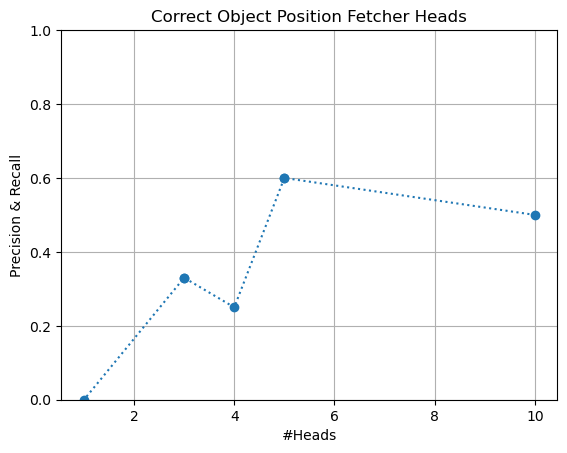

In [50]:
# Plot precision vs num_heads
plt.plot(num_heads, precision, "o:")
plt.xlabel("#Heads")
plt.ylabel("Precision & Recall")
plt.title("Correct Object Position Fetcher Heads")
plt.ylim(0, 1)
plt.grid()
plt.show()